In [2]:
import collections
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Classes

In [3]:
# maze example
import numpy as np
import collections
class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        pos = np.where(self._map == 'S')
        self.start_pos = [pos[0][0], pos[1][0]]
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'S':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            print("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
        
    def greedy(self, s):
        return np.argmax(self.Q[s[0], s[1]])

    def epsilon_greed(self, e,s):
        if np.random.rand() < e:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
    
    def train(self, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            self.env.init(self.env.start_pos)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
            
                # update self.Q table 
                self.Q[s[0],s[1],a] += alpha*(r + gamma * np.max(self.Q[s1[0],s1[1],:]) - self.Q[s[0],s[1],a])
                
                if self.env.is_goal(): # reached the goal
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, maxstep=1000):
        self.env.init(self.env.start_pos)
        s = self.env.get_cur_state()
        a = np.argmax(self.Q[s[0], s[1], :])
        trace = np.array(coord_convert(s, self.size))
        for step in range(maxstep):
            self.env.next(a)
            s1 = self.env.get_cur_state()
            a1 = np.argmax(self.Q[s1[0], s1[1],:])
            trace = np.vstack((trace, coord_convert(s1, self.size)))
            if self.env.is_goal():  # reached the goal
                break
            a = a1
        
        return trace

# Plotting Helpers

In [5]:
def plot_trace(agent, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(agent.env.goal_pos[1], agent.size[0]-agent.env.goal_pos[0]-1, 'G')
    plt.text(agent.env.start_pos[1], agent.size[0]-agent.env.start_pos[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(agent.env.goal_pos[1], agent.size[0]-agent.env.goal_pos[0]-1, 'G')
    plt.text(agent.env.start_pos[1], agent.size[0]-agent.env.start_pos[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, trace, "trace of the last episode")

    plt.plot()

# Assignment

In [6]:
env = GridWorld("mazes/60_rl.txt")
env.print_map()

[['H' 'H' 'H' ... 'H' 'H' 'H']
 ['H' 'O' 'O' ... 'O' 'S' 'H']
 ['H' 'H' 'O' ... 'O' 'H' 'H']
 ...
 ['H' 'H' 'O' ... 'H' 'O' 'H']
 ['H' 'O' 'O' ... 'O' 'G' 'H']
 ['H' 'H' 'H' ... 'H' 'H' 'H']]


<ipython-input-3-e1610ef2e653>:70: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  if isinstance(s, collections.Iterable) and len(s) == 2:
Training Time: 56.23s


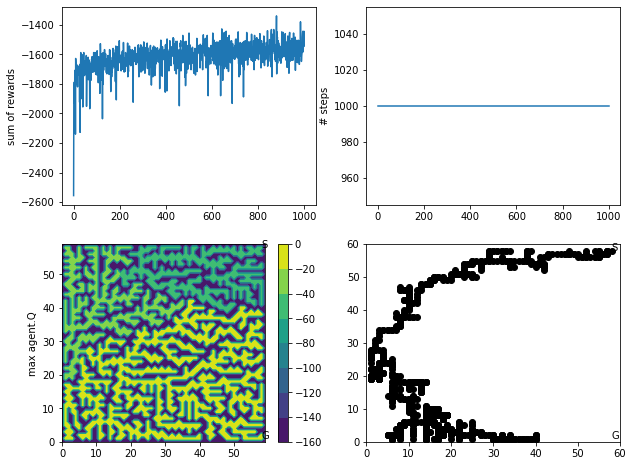

In [7]:
agent = RLAgent(env)
startTrain = time.time()
rtrace, steps, trace = agent.train(gamma=0.99, #Discount Rate - no tuning required
                                   alpha=0.1, #Learning Rate - need tuning
                                   epsilon=0.2, #Increases the explorability of the training - need tuning
                                   maxiter=1000, #Allow more iterations to better explore state space
                                   maxstep=2000) #How many steps per iteration
endTrain = time.time()
print("Training Time: " + "{:.2f}".format(endTrain-startTrain) + 's')
plot_train(agent, rtrace, steps, trace)

Testing Time: 0.0618
Path Length: 1000


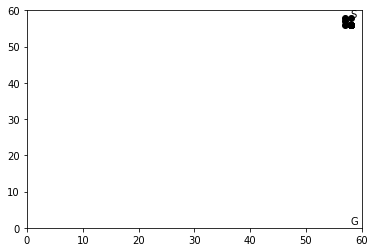

In [8]:
startTest = time.time()
test_trace = agent.test()
endTest = time.time()
print("Testing Time: " + "{:.4f}".format(endTest-startTest))
plot_trace(agent, test_trace)
print("Path Length: " + str(len(test_trace)-1))